# **Import Libary**

In [1]:
# --- Library untuk manipulasi data ---
import pandas as pd
import numpy as np

# --- Library untuk visualisasi data ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Library untuk preprocessing dan pemodelan ---
# Memisahkan data
from sklearn.model_selection import train_test_split
# Untuk menangani data kategorikal dan numerik
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Untuk membuat alur kerja yang rapi
from sklearn.pipeline import Pipeline

# --- Model Machine Learning ---
# Model dasar sebagai pembanding
from sklearn.linear_model import LogisticRegression
# Model ensemble yang kuat
from sklearn.ensemble import RandomForestClassifier
# Model gradient boosting yang sangat populer dan powerful
import xgboost as xgb

# --- Library untuk evaluasi model ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# --- Pengaturan default untuk visualisasi ---
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 7)

# **Memuat & Eksplorasi Data (EDA - Exploratory Data Analysis)**

In [2]:
# Memuat dataset dari file yang sudah di-upload
try:
    df = pd.read_csv('data2.csv')
    print("✅ Dataset 'data2.csv' berhasil dimuat.")
except FileNotFoundError:
    print("❌ ERROR: File 'data2.csv' tidak ditemukan. Pastikan file sudah di-upload ke Colab.")
    # Hentikan eksekusi jika file tidak ada
    exit()

✅ Dataset 'data2.csv' berhasil dimuat.


In [3]:
# Menampilkan 5 baris pertama data untuk melihat isinya
print("\n5 Baris Pertama Data:")
print(df.head())


5 Baris Pertama Data:
  Profession  Income   Credit_card_number Expiry  Security_code  Fraud
0     DOCTOR   42509     3515418493460774  07/25            251      1
1     DOCTOR   80334      213134223583196  05/32            858      1
2     LAWYER   91552     4869615013764888  03/30            755      1
3     LAWYER   43623      341063356109385  01/29            160      1
4     DOCTOR   22962  4707418777543978402  11/30            102      0


In [4]:
# Menampilkan informasi dasar (tipe data, jumlah data non-null)
print("\nInformasi Dataset:")
df.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Profession          10000 non-null  object
 1   Income              10000 non-null  int64 
 2   Credit_card_number  10000 non-null  int64 
 3   Expiry              10000 non-null  object
 4   Security_code       10000 non-null  int64 
 5   Fraud               10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


In [5]:
# Menampilkan statistik deskriptif untuk kolom numerik (Income)
print("\nStatistik Deskriptif:")
print(df.describe())


Statistik Deskriptif:
            Income  Credit_card_number  Security_code         Fraud
count  10000.00000        1.000000e+04   10000.000000  10000.000000
mean   49761.20600        3.851363e+17     863.587800      0.501600
std    28837.72928        1.257950e+18    1484.424959      0.500022
min        1.00000        6.040296e+10       0.000000      0.000000
25%    24863.75000        1.800137e+14     275.000000      0.000000
50%    49483.00000        3.512440e+15     539.500000      1.000000
75%    74483.00000        4.594779e+15     813.250000      1.000000
max    99986.00000        4.999697e+18    9990.000000      1.000000


In [6]:
# --- Analisa Target Variable 'Fraud' ---
print("\nDistribusi Kelas (Fraud vs Legitimate):")
fraud_counts = df['Fraud'].value_counts()
print(fraud_counts)


Distribusi Kelas (Fraud vs Legitimate):
Fraud
1    5016
0    4984
Name: count, dtype: int64


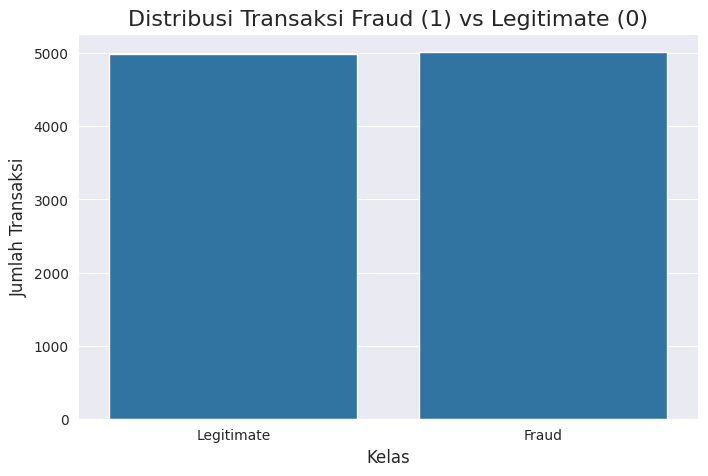

In [7]:
# Visualisasi distribusi kelas
plt.figure(figsize=(8, 5))
sns.countplot(x='Fraud', data=df)
plt.title('Distribusi Transaksi Fraud (1) vs Legitimate (0)', fontsize=16)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Transaksi', fontsize=12)
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.show()

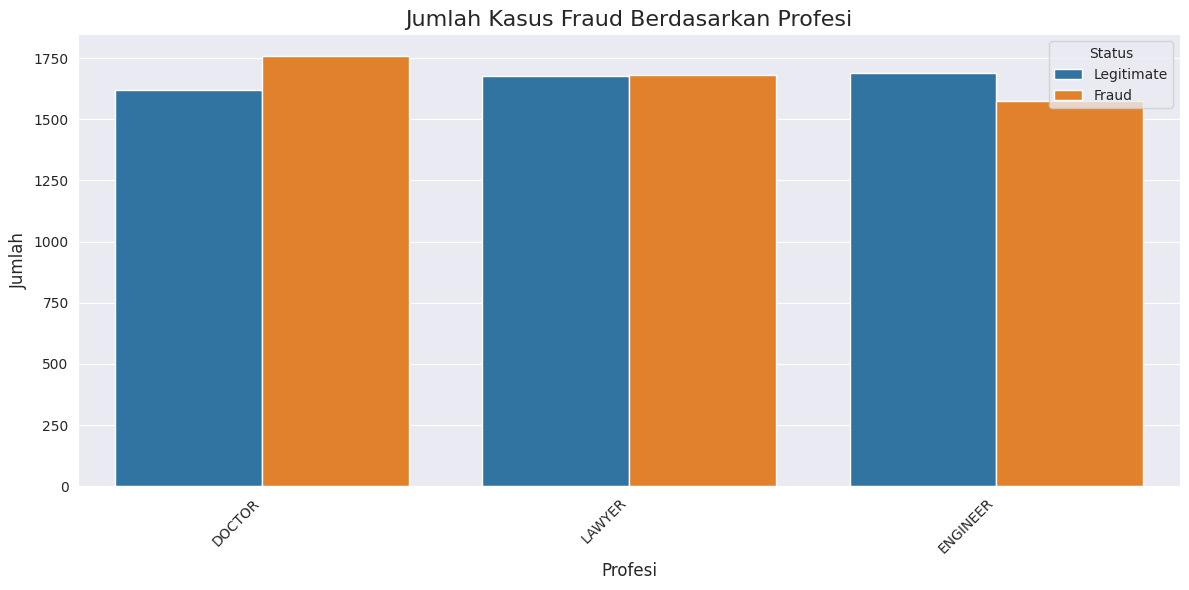

In [8]:
# --- Analisa Hubungan Fitur dengan Fraud ---
# Profesi vs Fraud
plt.figure(figsize=(12, 6))
sns.countplot(x='Profession', hue='Fraud', data=df)
plt.title('Jumlah Kasus Fraud Berdasarkan Profesi', fontsize=16)
plt.xlabel('Profesi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status', labels=['Legitimate', 'Fraud'])
plt.tight_layout()
plt.show()

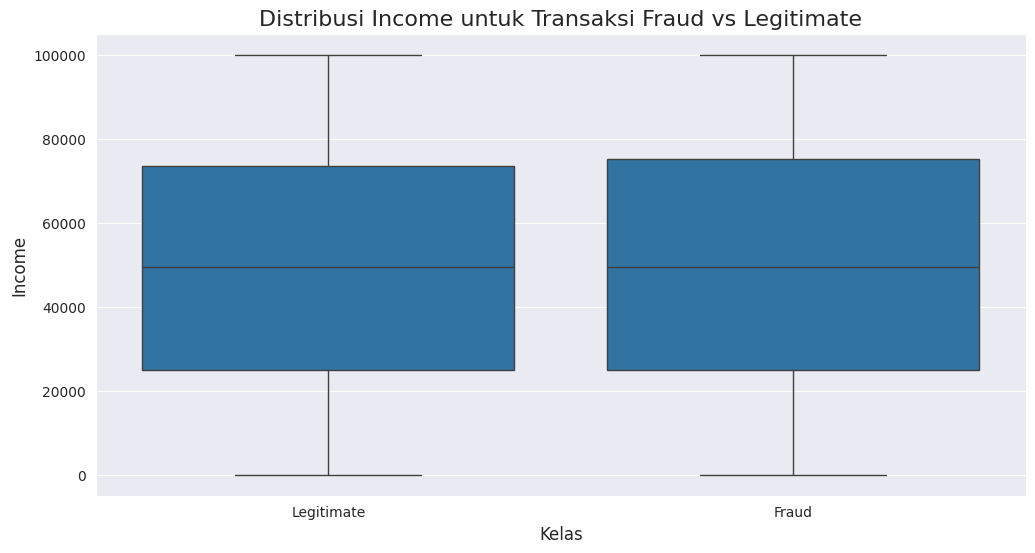

In [9]:
# Distribusi Income untuk setiap kelas
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fraud', y='Income', data=df)
plt.title('Distribusi Income untuk Transaksi Fraud vs Legitimate', fontsize=16)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.show()

# **Pra-pemrosesan Data (Data Preprocessing)**

In [11]:
# --- Feature Engineering & Selection ---
# Penjelasan: Kolom 'Credit Card Number', 'Expiry', dan 'Security Code' adalah
# data identifier yang sangat unik untuk setiap transaksi. Jika kita gunakan,
# model akan 'menghafal' nomor kartu tertentu, bukan belajar pola umum penipuan.
# Ini disebut 'data leakage' dan membuat model tidak berguna untuk data baru.
# Oleh karena itu, kolom-kolom ini wajib dibuang.

features_to_drop = ['Credit_card_number', 'Expiry', 'Security_code']
df_processed = df.drop(columns=features_to_drop)
print(f"✅ Kolom {features_to_drop} berhasil dibuang.")

✅ Kolom ['Credit_card_number', 'Expiry', 'Security_code'] berhasil dibuang.


In [12]:
# Memisahkan fitur (X) dan target (y)
X = df_processed.drop('Fraud', axis=1)
y = df_processed['Fraud']

In [13]:
# Mengidentifikasi tipe kolom
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nKolom Numerik: {numerical_features}")
print(f"Kolom Kategorikal: {categorical_features}")


Kolom Numerik: ['Income']
Kolom Kategorikal: ['Profession']


In [14]:
# --- Membuat Preprocessing Pipeline ---
# Pipeline ini adalah cara profesional untuk menerapkan transformasi data.
# 1. Untuk data numerik ('Income'): Skalanya akan disamakan menggunakan StandardScaler.
# 2. Untuk data kategorikal ('Profession'): Akan diubah menjadi angka menggunakan OneHotEncoder.
#    'handle_unknown='ignore'' penting agar model tidak error jika menemukan profesi baru di data tes.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Jaga kolom lain jika ada (untuk fleksibilitas)
)

print("\n✅ Pipeline preprocessing berhasil dibuat.")


✅ Pipeline preprocessing berhasil dibuat.


# **Membagi Data (Train-Test Split)**

In [15]:
# Membagi data menjadi 80% data training dan 20% data testing
# 'stratify=y' SANGAT PENTING! Ini memastikan proporsi kasus fraud dan non-fraud
# di data training dan testing sama dengan proporsi di dataset asli.
# Ini krusial untuk dataset yang tidak seimbang (imbalanced).

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% data untuk testing
    random_state=42,    # Agar hasil pembagian data selalu sama
    stratify=y          # Menjaga proporsi kelas target
)

print(f"Ukuran Data Training: {X_train.shape}")
print(f"Ukuran Data Testing: {X_test.shape}")
print(f"Proporsi Fraud di Data Training: {round(y_train.value_counts(normalize=True)[1], 3)}")
print(f"Proporsi Fraud di Data Testing: {round(y_test.value_counts(normalize=True)[1], 3)}")

Ukuran Data Training: (8000, 2)
Ukuran Data Testing: (2000, 2)
Proporsi Fraud di Data Training: 0.502
Proporsi Fraud di Data Testing: 0.501


# **Melatih Model Machine Learning**

In [16]:
# --- Model 1: Logistic Regression (Sebagai Baseline) ---
# Model ini simpel dan cepat, bagus sebagai titik awal perbandingan.
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced')) # class_weight 'balanced' membantu model pada data imbalanced
])
pipeline_lr.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [17]:
# --- Model 2: Random Forest ---
# Model ensemble yang kuat dan seringkali memberikan hasil yang bagus.
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])
pipeline_rf.fit(X_train, y_train)
print("✅ Model Random Forest berhasil dilatih.")

✅ Model Random Forest berhasil dilatih.


In [18]:
# --- Model 3: XGBoost ---
# Salah satu model terkuat untuk data tabular. Sering jadi juara di kompetisi.
# Kita perlu menghitung 'scale_pos_weight' untuk menangani data imbalanced di XGBoost.
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
])
pipeline_xgb.fit(X_train, y_train)
print("✅ Model XGBoost berhasil dilatih.")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:42:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model XGBoost berhasil dilatih.


# **Evaluasi Performa Model**

In [19]:
# Membuat dictionary untuk menyimpan model yang sudah dilatih
models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "XGBoost": pipeline_xgb
}

In [20]:
# Menyimpan hasil untuk perbandingan akhir
results_summary = []

--- Evaluasi Model: Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.52      0.41      0.46       997
       Fraud       0.52      0.63      0.57      1003

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.51      2000



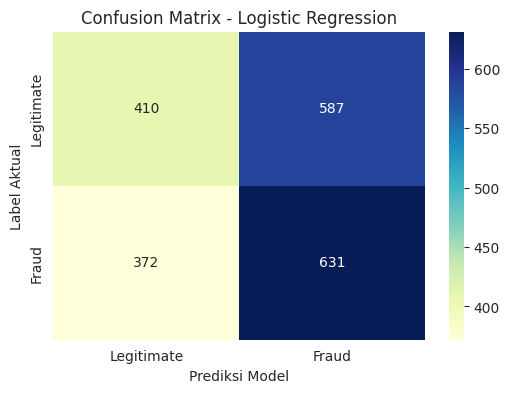

ROC-AUC Score: 0.5296

------------------------------------------------------------
--- Evaluasi Model: Random Forest ---
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.50      0.52      0.51       997
       Fraud       0.50      0.48      0.49      1003

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



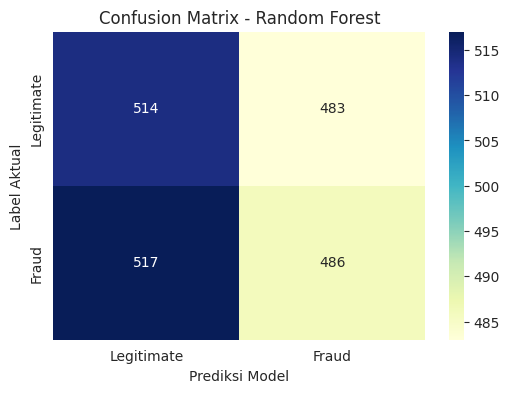

ROC-AUC Score: 0.5005

------------------------------------------------------------
--- Evaluasi Model: XGBoost ---
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.51      0.51      0.51       997
       Fraud       0.51      0.51      0.51      1003

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



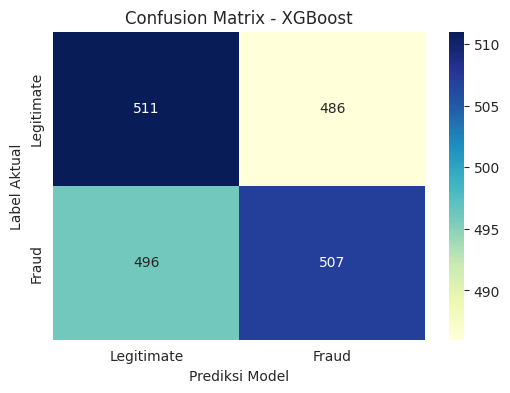

ROC-AUC Score: 0.5043

------------------------------------------------------------


In [24]:
# Looping untuk mengevaluasi setiap model
for name, model in models.items():
    print(f"--- Evaluasi Model: {name} ---")

    # Membuat prediksi pada data tes
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probabilitas untuk kelas 1 (Fraud)

    # Menampilkan Classification Report
    # Ini memberikan ringkasan Precision, Recall, F1-Score
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

    # Menampilkan Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Aktual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Menghitung & menyimpan metrik penting
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_fraud = report['1']['precision'] # Use '1' for Fraud
    recall_fraud = report['1']['recall']     # Use '1' for Fraud
    f1_fraud = report['1']['f1-score']       # Use '1' for Fraud

    results_summary.append({
        'Model': name,
        'Precision (Fraud)': precision_fraud,
        'Recall (Fraud)': recall_fraud,
        'F1-Score (Fraud)': f1_fraud,
        'ROC-AUC': roc_auc
    })
    print(f"ROC-AUC Score: {roc_auc:.4f}\n")
    print("-" * 60)

In [25]:
# Menampilkan ringkasan hasil perbandingan model dalam format DataFrame
results_df = pd.DataFrame(results_summary)
print("\nRingkasan Perbandingan Model:")
display(results_df)


Ringkasan Perbandingan Model:


,Model,Precision (Fraud),Recall (Fraud),F1-Score (Fraud),ROC-AUC
0,Logistic Regression,0.518062,0.629113,0.568213,0.529621
1,Random Forest,0.501548,0.484546,0.492901,0.500545
2,XGBoost,0.510574,0.505484,0.508016,0.504278
3,Logistic Regression,0.518062,0.629113,0.568213,0.529621
4,Random Forest,0.501548,0.484546,0.492901,0.500545
5,XGBoost,0.510574,0.505484,0.508016,0.504278


# **Kesimpulan & Perbandingan Model**

In [26]:
# Membuat DataFrame dari hasil rangkuman
df_results = pd.DataFrame(results_summary)

In [27]:
# Mengurutkan berdasarkan metrik yang paling kita pedulikan (misal: F1-Score atau Recall)
df_results_sorted = df_results.sort_values(by='F1-Score (Fraud)', ascending=False).reset_index(drop=True)

print("🏆 Tabel Perbandingan Performa Model (Fokus pada Deteksi 'Fraud') 🏆")
print(df_results_sorted)

print("\n--- Analisis Akhir ---")
print("Dalam kasus deteksi penipuan, kita seringkali lebih memilih model dengan **Recall** yang tinggi.")
print("Kenapa? Karena lebih baik kita salah menandai transaksi sah sebagai fraud (False Positive),")
print("daripada kita kelewatan kasus fraud yang sebenarnya (False Negative). Kerugian dari False Negative jauh lebih besar.")
print("\nBerdasarkan tabel di atas, model dengan **Recall (Fraud)** dan **F1-Score (Fraud)** tertinggi adalah kandidat terbaik.")
print("Biasanya, **Random Forest** atau **XGBoost** akan menunjukkan performa yang jauh lebih unggul daripada Logistic Regression untuk tugas seperti ini.")

best_model_name = df_results_sorted.iloc[0]['Model']
print(f"\nModel terbaik untuk kasus ini kemungkinan adalah: **{best_model_name}**")

🏆 Tabel Perbandingan Performa Model (Fokus pada Deteksi 'Fraud') 🏆
                 Model  Precision (Fraud)  Recall (Fraud)  F1-Score (Fraud)  \
0  Logistic Regression           0.518062        0.629113          0.568213   
1  Logistic Regression           0.518062        0.629113          0.568213   
2              XGBoost           0.510574        0.505484          0.508016   
3              XGBoost           0.510574        0.505484          0.508016   
4        Random Forest           0.501548        0.484546          0.492901   
5        Random Forest           0.501548        0.484546          0.492901   

    ROC-AUC  
0  0.529621  
1  0.529621  
2  0.504278  
3  0.504278  
4  0.500545  
5  0.500545  

--- Analisis Akhir ---
Dalam kasus deteksi penipuan, kita seringkali lebih memilih model dengan **Recall** yang tinggi.
Kenapa? Karena lebih baik kita salah menandai transaksi sah sebagai fraud (False Positive),
daripada kita kelewatan kasus fraud yang sebenarnya (False Negative)